### 1 Python libraries for use in this notebook

In [183]:
import pandas as pd
import numpy as np
import os
import re

In [3]:
os.chdir('E:/data incubator/')
os.getcwd()

'E:\\data incubator'

### 2 Load the LinkedIn Company dataset

In [4]:
df_linkedin = pd.read_csv('temp_datalab_records_linkedin_company.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
industry_types = df_linkedin['industry'].unique()
industry_types[1]

'Aviation & Aerospace'

### 3 Find the most popular companies with most followers on LinkedIn in each industry

In [114]:
# len(industry_types)
top = pd.DataFrame(columns=['company_name', 'industry'])
for i in range(0, 75):
    df = df_linkedin[df_linkedin['industry']==industry_types[i]]
    #df = df.sort_values(by='followers_count', ascending=False)
    df = pd.pivot_table(df, index=['company_name'])
    df = df.sort_values(by='followers_count', ascending=False).reset_index(drop=False)
                                                                                                                   
    top = top.append({'company_name': df['company_name'].loc[0], 'industry': industry_types[i]}, ignore_index=True)

# number 76 has some problem and need to be processed separately
df = df_linkedin[df_linkedin['industry']==industry_types[76]]
df = pd.pivot_table(df, index=['company_name'])
df=df.reset_index(drop=False)
df.columns=df.columns.str.strip()
df=df.T.sort_values('followers_count', ascending=False, axis=1)
top = top.append({'company_name': df[30][0], 'industry': industry_types[76]}, ignore_index=True)
    
for i in range(76, len(industry_types)):
    df = df_linkedin[df_linkedin['industry']==industry_types[i]]
    df = pd.pivot_table(df, index=['company_name'])
    df = df.sort_values(by='followers_count', ascending=False).reset_index(drop=False)
                                                                                                                   
    top = top.append({'company_name': df['company_name'].loc[0], 'industry': industry_types[i]}, ignore_index=True)                

In [235]:
top.head()

,company_name,industry
0,Goldman Sachs,Investment Banking
1,Boeing,Aviation & Aerospace
2,Pfizer,Pharmaceuticals
3,Walmart,Retail
4,Johnson & Johnson,Hospital & Health Care


### 4 Scraping Indeed job information of the most popular companies with most followers on LinkedIn
Be aware: LinkedIn may have some restriction for web scraping. So I test scraping job information from Indeed.

#### 4.1 Import neccessary libraries for scraping
package needed: BeautifulSoup, selenium for scraping

In [261]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time
import urllib
# !pip install selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import urllib.request
from html.parser import HTMLParser
import tqdm
from tqdm import tqdm_notebook as tqdm
from time import sleep
import nltk
from datetime import date
import matplotlib.pyplot as plt

#### 4.2 Scrape and generate pandas dataframe for further analysis
Citations: Code integrated from [Medium post - Web Scraping Job Postings from Indeed](https://medium.com/@msalmon00/web-scraping-job-postings-from-indeed-96bd588dcb4b), [Romtein github repo of web scraper](https://github.com/Romtein/Indeed-Python-Scraper/blob/master/Indeed%20Scraper.ipynb), and [developer community post - web scraping walkthrough with Python](https://dev.to/awwsmm/web-scraping-walkthrough-with-python-85c) with modification

##### 4.2.1 Extract all information from the provided url on Indeed
Use Goldman Sachs in Investment Banking industry category as an example

In [230]:
# Use Goldman Sachs in Investment Banking as an example
url = "https://www.indeed.com/jobs?q=goldman+sachs&l=New+York+State"

#conducting a request of the stated URL above:
page = requests.get(url)

#specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
soup = BeautifulSoup(page.text, 'html.parser')

#printing soup in a more structured tree format that makes for easier reading
# print(soup.prettify())

##### 4.2.2 Job title extraction

In [245]:
def extract_job_title_from_result(soup): 
    jobs = []
    for div in soup.find_all(name='div', attrs={'class':'row'}):
        for a in div.find_all(name='a', attrs={'data-tn-element':'jobTitle'}):
            jobs.append(a['title'])
    return(jobs)
extract_job_title_from_result(soup)[:6]

['CIMD - Marcus by Goldman Sachs - Data Scientist',
 'iOS Developer - CIMD - Marcus by Goldman Sachs',
 'Back-End Developer - CIMD - Marcus by Goldman Sachs',
 'CIMD - Marcus by Goldman Sachs – CRM Manager – Analyst - New York City',
 'Front-End Developer - CIMD - Marcus by Goldman Sachs',
 'Android Developer - CIMD - Marcus by Goldman Sachs']

##### 4.2.3 Check if company name match

In [243]:
def extract_company_from_result(soup): 
    companies = []
    for div in soup.find_all(name='div', attrs={'class':'row'}):
        company = div.find_all(name='span', attrs={'class':'company'})
        if len(company) > 0:
            for b in company:
                companies.append(b.text.strip())
        else:
            sec_try = div.find_all(name='span', attrs={'class':'result-link-source'})
            for span in sec_try:
                companies.append(span.text.strip())
    return(companies)
 
extract_company_from_result(soup)[:2]

['Goldman Sachs', 'Goldman Sachs']

##### 4.2.4 Job location extraction if no state selected

In [244]:
def extract_location_from_result(soup): 
    locations = []
    spans = soup.findAll('span', attrs={'class': 'location'})
    for span in spans:
        locations.append(span.text)
    return(locations)

extract_location_from_result(soup)[:2]

['New York, NY 10282 (Battery Park area)',
 'New York, NY 10282 (Battery Park area)']

##### 4.2.5 Job description extraction integrated with all information above

In [233]:
# download chromedriver for Windows, MacOS or Linux, store the file in the directory
chromedriver = "Z:/chromedriver_win32/chromedriver.exe"

driver = webdriver.Chrome(chromedriver)

def extract_summary_from_result(soup): 
    # job title, company name extraction with function above
    job_title = extract_job_title_from_result(soup)
    
    company_name = extract_company_from_result(soup)
    
    job_loc = extract_location_from_result(soup)
    
    summaries = pd.DataFrame(columns=['job url','job summary'])
    
    for adlink in soup.select('a[onmousedown*="rclk(this,jobmap"]'):
        suburl = "https://www.indeed.com"+adlink['href']
#         print(suburl)
        driver.get(suburl)
        
        htmlfile = urllib.request.urlopen(suburl)

        subpage = requests.get(suburl)

        subSOUP = BeautifulSoup(subpage.text, 'html.parser') 
        
        desc = driver.find_element_by_tag_name("body").get_attribute("innerText")
        [i.replace("\n", " ") for i in desc]
        
        summaries = summaries.append({'job url': suburl, 'job summary': desc}, ignore_index=True)
    
    # dataframe organization
    summaries['job title'] = job_title
    summaries['company name'] = company_name
    summaries['job location'] = job_loc
    cols = ['company name', 'job title', 'job location', 'job url', 'job summary']
    summaries = summaries[cols]
    
    return summaries

summary = extract_summary_from_result(soup)
summary.head()

,company name,job title,job location,job url,job summary
0,Goldman Sachs,iOS Developer - CIMD - Marcus by Goldman Sachs,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=a7533453cad2d...,Find jobs\nCompany reviews\nFind salaries\nUpl...
1,Goldman Sachs,CIMD - Marcus by Goldman Sachs - Data Scientist,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=04e2d50ddd515...,Find jobs\nCompany reviews\nFind salaries\nUpl...
2,Goldman Sachs,Back-End Developer - CIMD - Marcus by Goldman ...,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=471ef2dcfab9e...,Find jobs\nCompany reviews\nFind salaries\nUpl...
3,Goldman Sachs,CIMD - Marcus by Goldman Sachs – CRM Manager –...,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=37a9aefb1a689...,Find jobs\nCompany reviews\nFind salaries\nUpl...
4,Goldman Sachs,Global Portfolio Solutions (GPS) Strats - CIMD,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=8e09572056144...,Find jobs\nCompany reviews\nFind salaries\nUpl...


##### 4.2.6 Scraping first 20 pages of the most popular company with most followers on LinkedIn
Note: Scrape first 10 pages as an example

In [246]:
# Indeed jobs per page, and specify how many pages to be scraped 
web_pages = 20
job_per_page = 10
job_scraped = web_pages*job_per_page

# final result dataframe
rslt = pd.DataFrame(columns=['company name', 'job title', 'job location', 'job url', 'job summary'])

for page_num in tqdm(range(0, web_pages)):
    
    # space out each request, be gentle to the website
    time.sleep(2)
    
    search = 'https://www.indeed.com/jobs?q=goldman+sachs&l=New+York+State&start=' + str(job_per_page*page_num)
    
    #conducting a request of the stated URL above:
    page = requests.get(url)

    #specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
    soup = BeautifulSoup(page.text, 'html.parser')
    
    summary = extract_summary_from_result(soup)
    rslt = rslt.append(summary, ignore_index=True)

In [251]:
rslt.head()

,company name,job title,job location,job url,job summary
0,Goldman Sachs,CIMD - Marcus by Goldman Sachs - Data Scientist,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=04e2d50ddd515...,Find jobs\nCompany reviews\nFind salaries\nUpl...
1,Goldman Sachs,iOS Developer - CIMD - Marcus by Goldman Sachs,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=a7533453cad2d...,Find jobs\nCompany reviews\nFind salaries\nUpl...
2,Goldman Sachs,Back-End Developer - CIMD - Marcus by Goldman ...,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=471ef2dcfab9e...,Find jobs\nCompany reviews\nFind salaries\nUpl...
3,Goldman Sachs,CIMD - Marcus by Goldman Sachs – CRM Manager –...,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=37a9aefb1a689...,Find jobs\nCompany reviews\nFind salaries\nUpl...
4,Goldman Sachs,Front-End Developer - CIMD - Marcus by Goldman...,"New York, NY 10282 (Battery Park area)",https://www.indeed.com/rc/clk?jk=5098ed2ba88ab...,Find jobs\nCompany reviews\nFind salaries\nUpl...


##### 4.2.7 Explore most frequent jobs posted/needed
Note: 
- CIMD stands for CONSUMER AND INVESTMENT MANAGEMENT DIVISION
- GPS stands for Global Portfolio Solutions

Text(45.125, 0.5, 'keywords dist out of 200 total scraped jobs')

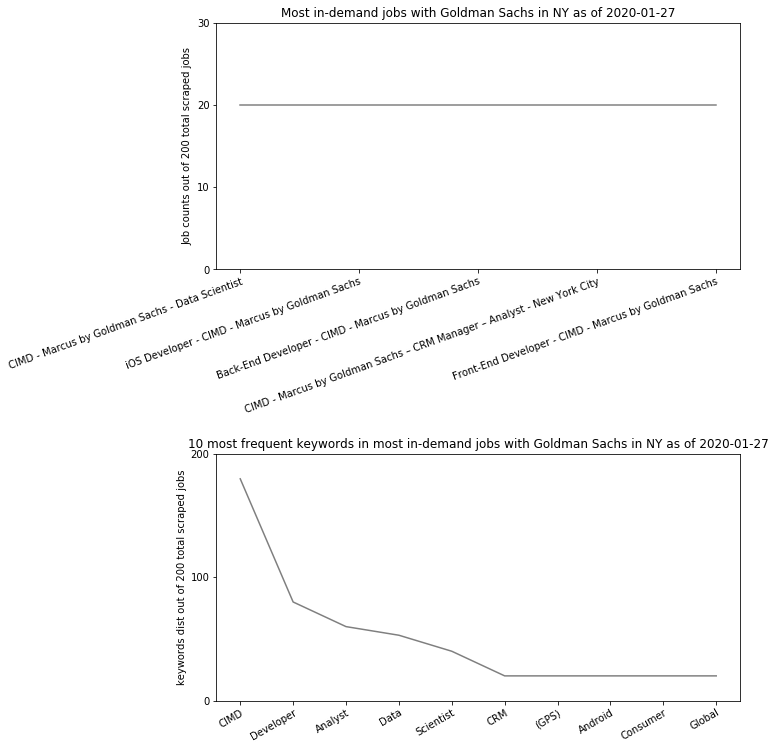

In [323]:
# job title
title_dist = nltk.FreqDist(rslt['job title'])
title_df = pd.DataFrame(title_dist.most_common(5),columns=['Word','Frequency'])
title_df = title_df.reset_index(drop=False)

# individual keywords in job titles
inv_word = pd.Series(np.concatenate([x.split() for x in rslt['job title']])).value_counts()
inv_word = inv_word.drop(['-', '–', 'Marcus', 'by', 'Goldman', 'Sachs', 'New', 'York', 'City', 'and'])
inv_word = inv_word.reset_index().reset_index()
inv_word = inv_word.rename(columns = {'level_0': 'ind', 'index': 'keyword', 0 : 'count'})
######## 
# Plot
########
fig, ax = plt.subplots(2, figsize=(8, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.75)
ax[0].plot(title_df['index'], title_df['Frequency'], color = 'black', alpha = 0.5)  
ax[0].set_title('Most in-demand jobs with Goldman Sachs in NY as of ' + str (date.today()))
ax[0].set_xticks([0,1,2,3,4]) 
ax[0].set_xticklabels(title_df['Word'], rotation=20, rotation_mode="anchor", ha="right")
ax[0].set_ylim(0, 25)
ax[0].set_yticks([0, 10, 20, 30])
ax[0].set_ylabel('Job counts out of ' + str(len(rslt)) + ' total scraped jobs')
ax[0].tick_params(axis='both', which='major', labelsize=10)

ax[1].plot(inv_word['ind'][:10], inv_word['count'][:10], color = 'black', alpha = 0.5)
ax[1].set_title('10 most frequent keywords in most in-demand jobs with Goldman Sachs in NY as of '+str (date.today()))
ax[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax[1].set_xticklabels(inv_word['keyword'], rotation=30, rotation_mode="anchor", ha="right")
ax[1].set_ylim(0, 200)
ax[1].set_yticks([0, 100, 200])
ax[1].set_ylabel('keywords dist out of ' + str(len(rslt)) + ' total scraped jobs')